In [3]:
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt 
import numpy as np

In [7]:
models = ["Our model ResNet18","ResNet18","ResNet101","PreActResNet","DenseNet", "VGG16"]
accuracy = [92.71, 93.02, 94.82, 95.11, 95.04, 92.64]
num_parameters = [11.2, 11.2, 44.5, 11.2, 8, 15]

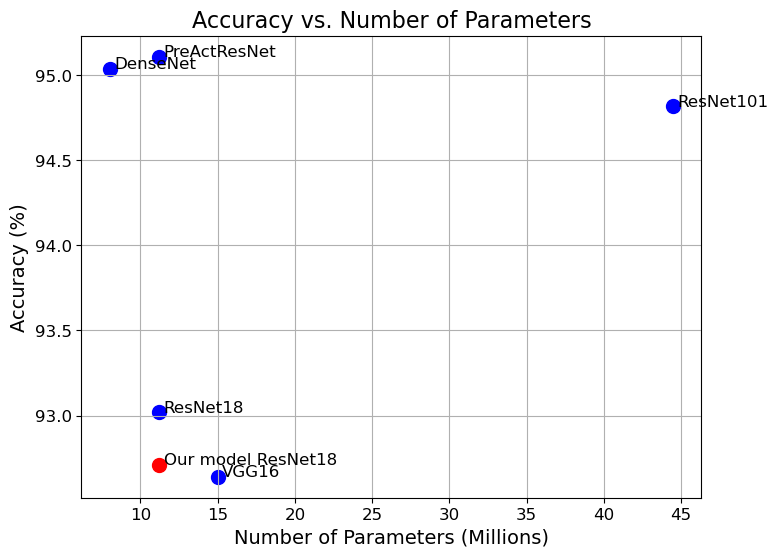

In [10]:
# Create scatter plot
plt.figure(figsize=(8, 6))

# Plot each point
for i, model in enumerate(models):
    color = 'red' if model == "Our model ResNet18" else 'blue'
    plt.scatter(num_parameters[i], accuracy[i], color=color, s=100)  # Red for our model

# Annotate each point with the model name
for i, model in enumerate(models):
    plt.text(num_parameters[i] + 0.3, accuracy[i], model, fontsize=12)

# Labels, title, and grid
plt.xlabel("Number of Parameters (Millions)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Accuracy vs. Number of Parameters", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

Files already downloaded and verified
(4, 3, 32, 32)


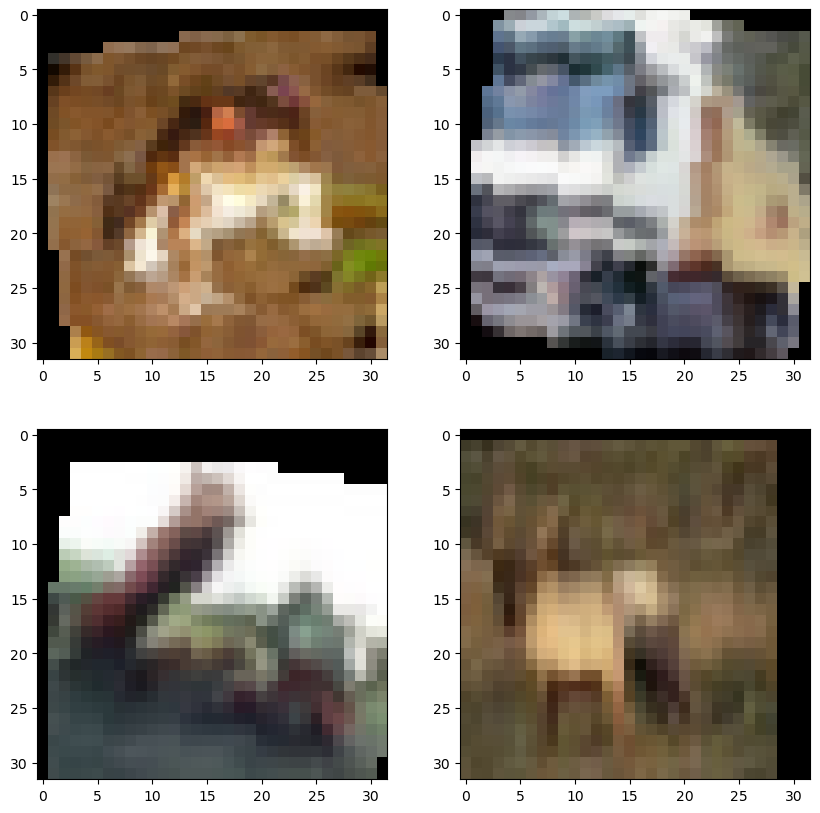

In [5]:
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

rootdir = '/opt/img/effdl-cifar10/'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)

trainloader = DataLoader(c10train,batch_size=4,shuffle=False) ### Shuffle to False so that we always see the same images

from matplotlib import pyplot as plt 

### Let's do a figure for each batch
f = plt.figure(figsize=(10,10))

for i,(data,target) in enumerate(trainloader):
    
    data = (data.numpy())
    print(data.shape)
    plt.subplot(2,2,1)
    plt.imshow(data[0].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,2)
    plt.imshow(data[1].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,3)
    plt.imshow(data[2].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,4)
    plt.imshow(data[3].swapaxes(0,2).swapaxes(0,1))

    break

f.savefig('train_DA.png')

In [2]:
# import model from the kuangliu repo 
from resnet import ResNet18

In [ ]:
# hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.01
is_scheduler = False

In [ ]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network.
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),

    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

### The data from CIFAR10 are already downloaded in the following folder
rootdir = '/opt/img/effdl-cifar10/'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

trainloader = DataLoader(c10train,batch_size=batch_size,shuffle=True)
testloader = DataLoader(c10test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 15000

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647

## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")

# Finally we can define anoter dataloader for the training data
trainloader_subset = DataLoader(c10train_subset,batch_size=batch_size,shuffle=True)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.

Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 15000 samples


## TASK 1. Train a model from scratch

In [6]:
# device conf : using GPU if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# define the model used
model = ResNet18()
model = model.to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Define a schedule which gonna divide the lr by 10 when reaching a plateau in performance for the accuracy
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

/opt/img/effdl-venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# use a scheduler to change the learning rate
# import librairies

In [10]:
def train_model(model, trainloader, testloader, epochs, is_scheduler):
    train_accuracy_list, test_accuracy_list = [], []
    train_loss_list, test_loss_list = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Training accuracy
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(running_loss / len(trainloader))

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * (correct_test / total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss / len(testloader))

        # if using a scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if is_scheduler:
            scheduler.step(test_loss / len(testloader))
            if current_lr != optimizer.param_groups[0]['lr']:
                print(f"LEARNING RATE UPDATE TO:{optimizer.param_groups[0]['lr']}")

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {running_loss/len(trainloader):.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Test Acc: {test_accuracy:.2f}% ",
              f"Learning Rate: {optimizer.param_groups[0]['lr']}")

    print("Training complete my boss")

    ############# PLOT THE LOSS AND THE ACCURACY PER EPOCH ####################
    epochs = range(1, num_epochs+1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
    
    # Loss plot
    axes[0].plot(epochs, train_loss_list, label="Training loss", color="blue")
    axes[0].plot(epochs, test_loss_list, label="Testing loss", color="red")
    axes[0].set_title("Training and testing loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Accuracy plot
    axes[1].plot(epochs, train_accuracy_list, label="Training accuracy", color="blue")
    axes[1].plot(epochs, test_accuracy_list, label="Testing accuracy", color="red")
    axes[1].set_title("Training and Testing accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()
    
    plt.tight_layout() 
    plt.show()
    #return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list 

Epoch 1: Train Loss: 2.1403, Train Acc: 23.97%, Test Acc: 35.11%  Learning Rate: 0.01
Epoch 2: Train Loss: 1.7217, Train Acc: 35.18%, Test Acc: 35.47%  Learning Rate: 0.01
Epoch 3: Train Loss: 1.5713, Train Acc: 41.69%, Test Acc: 40.30%  Learning Rate: 0.01
Epoch 4: Train Loss: 1.4520, Train Acc: 46.53%, Test Acc: 49.35%  Learning Rate: 0.01
Epoch 5: Train Loss: 1.3517, Train Acc: 50.43%, Test Acc: 52.94%  Learning Rate: 0.01
Epoch 6: Train Loss: 1.2532, Train Acc: 54.92%, Test Acc: 56.22%  Learning Rate: 0.01
Epoch 7: Train Loss: 1.1384, Train Acc: 59.21%, Test Acc: 56.73%  Learning Rate: 0.01
Epoch 8: Train Loss: 1.0506, Train Acc: 62.13%, Test Acc: 63.78%  Learning Rate: 0.01
Epoch 9: Train Loss: 0.9841, Train Acc: 64.61%, Test Acc: 65.13%  Learning Rate: 0.01
Epoch 10: Train Loss: 0.9122, Train Acc: 67.77%, Test Acc: 64.71%  Learning Rate: 0.01
Epoch 11: Train Loss: 0.8571, Train Acc: 69.33%, Test Acc: 69.79%  Learning Rate: 0.01
Epoch 12: Train Loss: 0.7836, Train Acc: 71.99%, Tes

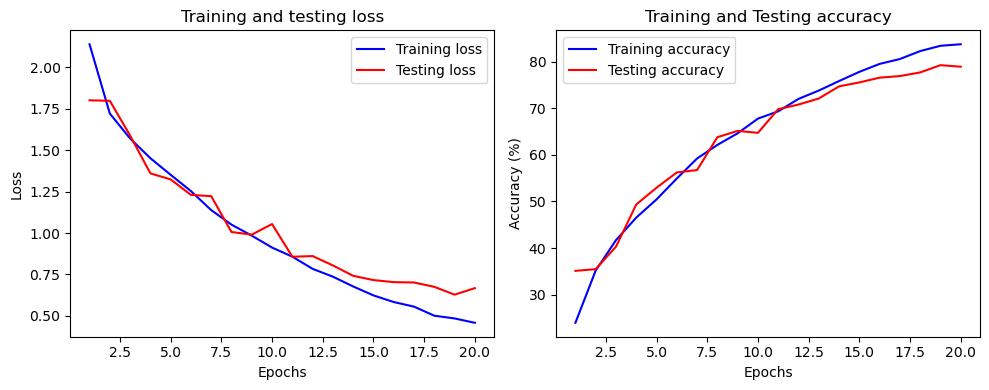

In [11]:
# Train the model
train_model(model, trainloader_subset, testloader, epochs=num_epochs, is_scheduler=is_scheduler)

In [12]:
# # Save the model
# check_point = {
#     "epoch": num_epochs,
#     "model_state": model.state_dict(),
#     "optimizer": "Adam",
#     "optim_state": optimizer.state_dict() ,
#     "is_scheduler": is_scheduler
# }
# if check_point["is_scheduler"]:
#     check_point["scheduler"]=scheduler
    
# torch.save(check_point, './model_state/resnet18_model_simple.pth')

In [13]:
# # We load the dictionary
# loaded_cpt = torch.load('./model_state/resnet18_model_simple.pth')

# new_model = ResNet18()
# new_model.load_state_dict(loaded_cpt['model_state'])

In [14]:
# TO DO:

# 1) Presentation of the assigned paper (ResNet)

# 2) Hyperparameter exploration strategy (C10 full)

#   a) Architecture HP
#       - Type (ResNet, DenseNet, etc.)
#       - Depth (nb of layers)
#       - Width (nb of filter per layer, growthrate, etc.)

#   b) Training
#       - Optimizer (SGD, Adam, etc.)
#       - Learning rate, scheduler
#       - Nb of epochs
#       - Regularization ( weight decay)
#       - Data augmentation (to struggle overfitting)
#       - batch size


In [15]:
# Currently, we are underfitting, we have to overfit first then fight overfitting.
# I've increased the batch size and as a result, the accuracy and loss increased and decreased respectively. 
# However, the model is still not overfitting, why? -> No generalization power? Model capacity limitation? -> more layer? change the achitecture?
# --> use the full dataset to see if the problem is persisting 

# Do we have to remove the transform (DA) ?